In [480]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import timedelta, date, datetime
from sqlalchemy.types import NVARCHAR, DATE, FLOAT, VARCHAR, DATETIME
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve,\
    plot_confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from helpers import *

data_dir = "../data"

sns.set_style('whitegrid')



## Feature extraction

In [391]:
from sqlalchemy import create_engine
import pandas as pd
import config
from sql_queries import *

engine = create_engine(
    f"mysql+pymysql://{config.sql_credentials['user']}:{config.sql_credentials['password']}@{config.sql_credentials['host']}:{config.sql_credentials['port']}/{config.sql_credentials['db']}",
    pool_pre_ping=True)

conn = engine.connect()
#
# print(datetime.now())
# login_data = pd.read_sql(login_query, conn)
# print(datetime.now())
# dist_data = pd.read_sql(dist_query, conn)
# print(datetime.now())
# prefs_data = pd.read_sql(prefs_query, conn)
# print(datetime.now())
# training_data = pd.read_sql(training_query, conn)
# print(datetime.now())
# worked_data = pd.read_sql(worked_query, conn)
# print(datetime.now())
# days_worked_data = pd.read_sql(days_worked_query,conn)
# print(datetime.now())
# apps_done_data = pd.read_sql(apps_done_query,conn)
# print(datetime.now())
# logs_done_data = pd.read_sql(logs_done_query,conn)
# print(datetime.now())
# print(datetime.now())
# texts_received_data = pd.read_sql(texts_received_query, conn)
# print(datetime.now())
# login_events_data = pd.read_sql(logins_events_query, conn)
# print(datetime.now())
# views_done_data = pd.read_sql(views_done_query, conn)
# print(datetime.now())
# pvs_data = pd.read_sql(pvs_query, conn)
# print(datetime.now())
# md_data = pd.read_sql(md_query, conn)
# print(datetime.now())
# customer_pop_data = pd.read_sql(customer_popularity_query,conn)
# print(datetime.now())
#
# customer_pop_data.to_csv('../data/customer_popularity_data.csv', index = False)
# md_data.to_csv('../data/md_data.csv', index = False)#
# pvs_data.to_csv('../data/pvs_data.csv', index = False)
# views_done_data.to_csv('../data/views_done_data.csv', index = False)
# login_events_data.to_csv('../data/login_events_data.csv', index = False)
# days_worked_data.to_csv('../data/days_worked_data.csv', index = False)
# logs_done_data.to_csv('../data/logs_done_data.csv', index = False)
# apps_done_data.to_csv('../data/apps_done_data.csv', index = False)
# login_data.to_csv('../data/login_data.csv', index = False)
# dist_data.to_csv('../data/dist_data.csv', index = False)
# worked_data.to_csv('../data/worked_data.csv', index = False)
# prefs_data.to_csv('../data/prefs_data_v2.csv', index = False)
# training_data.to_csv('../data/training_data_v2.csv', index = False)
# texts_received_data.to_csv('../data/texts_received_data.csv', index = False)


## Feature engineering

In [230]:
login_data = pd.read_csv('../data/login_data.csv')
dist_data = pd.read_csv('../data/dist_data.csv')
worked_data = pd.read_csv('../data/worked_data.csv')
prefs_data = pd.read_csv('../data/prefs_data_v2.csv')
training_data = pd.read_csv('../data/training_data_v2.csv')
days_worked_data = pd.read_csv('../data/days_worked_data.csv')
apps_done_data = pd.read_csv('../data/apps_done_data.csv')
logs_done_data = pd.read_csv('../data/logs_done_data.csv')
texts_received_data = pd.read_csv('../data/texts_received_data.csv')
# logins_events_data = pd.read_csv('../data/login_events_data.csv')
views_done_data = pd.read_csv('../data/views_done_data.csv')
pvs_data = pd.read_csv('../data/pvs_data.csv')
md_data = pd.read_csv('../data/md_data.csv')
customer_pop_data = pd.read_csv('../data/customer_popularity_data.csv')

In [439]:
logs_done_data_30 = pd.read_csv('../data/logs_done_data_30.csv')

In [440]:
customer_pop_data['date'] = customer_pop_data.date.apply(lambda x:str(x))
days_worked_data['date'] = days_worked_data.date.apply(lambda x:str(x))
logs_done_data['date'] = logs_done_data.date.apply(lambda x:str(x))
texts_received_data['date'] = texts_received_data.date.apply(lambda x:str(x))
apps_done_data['date'] = apps_done_data.date.apply(lambda x:str(x))
views_done_data['date'] = views_done_data.date.apply(lambda x:str(x))
pvs_data['sent_at'] = pvs_data['sent_at'].apply(lambda x:str(x))
md_data['sent_at'] = md_data['sent_at'].apply(lambda x:str(x))
logs_done_data_30['date'] = logs_done_data_30.date.apply(lambda x:str(x))

training_data['date_sent_at'] = pd.to_datetime(training_data['sent_at'],format='%Y-%m-%d').dt.date.apply(lambda x:str(x))

print(training_data.shape)
all_data = training_data.merge(login_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(prefs_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(dist_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(worked_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
all_data = all_data.merge(days_worked_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(apps_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(logs_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(texts_received_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data = all_data.merge(views_done_data, how='left', left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)
all_data.drop(['date_x','date_y'],axis=1, inplace = True)
print(all_data.shape)
all_data = all_data.merge(pvs_data, how='left', left_on = ['sent_at','carer_id'],
                          right_on = ['sent_at','carer_id'])
print(all_data.shape)
all_data = all_data.merge(md_data, how='left', on = ['placement_ad_id','carer_id','sent_at'])
print(all_data.shape)
# all_data = all_data.merge(customer_pop_data, how='left',left_on = ['date_sent_at','customer_id'],
#                           right_on = ['date','customer_id'])
# print(all_data.shape)
all_data = all_data.merge(logs_done_data_30, how='left',left_on = ['date_sent_at','carer_id'],
                          right_on = ['date','carer_id'])
print(all_data.shape)


all_data.drop_duplicates(subset=['placement_ad_id','carer_id','sent_at'], inplace = True)
print(all_data.shape)


target = 'carer_applied_in_8hrs'

(2246563, 39)
(2246563, 40)
(2246563, 70)
(2246563, 72)
(2246563, 75)
(2246563, 77)
(2246563, 79)
(2246563, 77)
(2246563, 79)
(2246563, 81)
(2246563, 83)
(2246563, 81)
(2246563, 82)
(2246563, 83)
(2246563, 85)
(1963934, 85)


In [185]:
print(f'There are {all_data[target].sum()} applications for {all_data.placement_ad_id.nunique()} placement ads')

There are 17072 applications for 15000 placement ads


In [474]:
all_data.groupby('sms_type')[target].sum()/all_data.groupby('sms_type')[target].count()

sms_type
customListSent            0.006471
initialPromotionSent      0.020116
preferredPlacementSent    0.017080
returningCarerSent        0.008100
slowMatchingSent          0.011636
urgentMatchSent           0.007809
Name: carer_applied_in_8hrs, dtype: float64

In [475]:
all_data[target].mean()

0.008692756477559837

### Data preparation

In [481]:
target = 'carer_applied_in_8hrs'

X1 = all_data.loc[all_data['carer_applied_in_8hrs']==1]
X0 = all_data.loc[(all_data['carer_applied_in_8hrs']==0)].sample(frac=0.01, random_state=1992)
#&(all_data.avg_popularity_score.notnull())
df = pd.concat([X1,X0], axis = 0)
df

,placement_ad_id,match_request_id,carer_id,customer_id,sent_at,updated_at,sms_type,carer_applied_in_8hrs,lead_time,ongoing,...,days_worked_past_90,apps_past_7_days,login_past_7_days,texts_past_30_days,date_x,viewed_placements_past_7_days,predicted_value,difficulty_normalised,date_y,login_past_30_days
19,plad_pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9...,pl_s062kkx0J0QL_j4cB-d1dabaa0-acbb-4dc1-9754-c...,p100093502,c1708384805,2021-08-17 11:29:26,2021-08-17 11:28:26,initialPromotionSent,1,34,1,...,7.0,3.0,43.0,83.0,2021-08-17,5.0,NaN,NaN,2021-08-17,145.0
27,plad_pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a...,pl_s01HFZJkHmIL_4BaD-19e7269b-1f1e-4281-a4c1-2...,p100139148,c065288332,2019-12-30 11:44:46,2019-12-30 11:36:45,initialPromotionSent,1,7,0,...,25.0,21.0,45.0,53.0,NaN,NaN,NaN,0.568004,2019-12-30,95.0
82,plad_pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8...,pl_s0SmL39RWSVK_buQY-7a0c3a05-036b-453c-8ed6-8...,p100139148,c230653087,2020-02-07 16:44:36,2020-02-07 16:36:02,initialPromotionSent,1,4,1,...,29.0,NaN,15.0,97.0,NaN,NaN,NaN,1.604750,2020-02-07,73.0
149,plad_pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8...,pl_s0cCuetHrFmd_00QZ-dd9a0882-3ea3-4362-8c3c-a...,p100146905,c4492717382,2021-07-02 16:17:30,2021-07-02 16:08:38,initialPromotionSent,1,5,0,...,NaN,NaN,NaN,100.0,NaN,NaN,139.8040,1.705170,2021-07-02,3.0
430,plad_pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a...,pl_s063CSCZAYUm_4jbo-e89250f1-628c-4d24-a59b-a...,p100481747,c100238187,2020-08-17 11:45:35,2020-08-17 11:28:30,initialPromotionSent,1,7,1,...,NaN,1.0,17.0,23.0,NaN,NaN,84.1962,1.270840,2020-08-17,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283285,plad_pl_s0dipnm56vU6_BG3x-beb7b292-1a54-4bc9-8...,pl_s0dipnm56vU6_BG3x-beb7b292-1a54-4bc9-8777-3...,p573464,c123727200,2020-06-12 10:12:42,2020-06-12 08:58:18,customListSent,0,3,0,...,42.0,4.0,36.0,91.0,2020-06-12,6.0,NaN,1.143570,2020-06-12,147.0
1767601,plad_pl_s0oQACzhYn61_jkZg-ceb1ca09-232f-4301-9...,pl_s0oQACzhYn61_jkZg-ceb1ca09-232f-4301-933c-b...,p163113365,c7271210046,2020-09-18 11:35:25,2020-09-18 08:46:04,customListSent,0,5,1,...,NaN,NaN,NaN,156.0,NaN,NaN,100.9210,1.775360,2020-09-18,3.0
1010757,plad_pl_s03YivoXJ1lA_tZHU-d7220c1a-0df3-46f9-8...,pl_s03YivoXJ1lA_tZHU-d7220c1a-0df3-46f9-8b26-e...,p254565487,c232567191,2021-02-12 11:28:00,2021-02-11 14:05:31,customListSent,0,3,0,...,45.0,NaN,2.0,46.0,NaN,NaN,NaN,1.596730,2021-02-12,78.0
1158244,plad_pl_s0A62FCskFAS_W6dS-8b8fcaa5-1a60-42fb-9...,pl_s0A62FCskFAS_W6dS-8b8fcaa5-1a60-42fb-93e8-9...,p255958616,c159683336,2020-07-15 16:23:36,2020-07-15 14:27:17,customListSent,0,2,0,...,10.0,NaN,NaN,36.0,NaN,NaN,146.1500,1.885940,2020-07-15,19.0


In [ ]:
pp = [
'difficulty_normalised',
    'carer_gender_FEMALE','lead_time','distance_km',
    'has_dogs','log_years_on_elder', 'max_cr_age',
     'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male','popularity_score']
for f in pp:
    plot_histogram(f, all_data)

In [ ]:
for f in pp:
    plot_histogram(f, df)


In [482]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'predicted_value'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [483]:
df = df.loc[df.lead_time>0]
df['texts_past_30_days'].replace(np.nan,0,inplace = True)
df['login_past_7_days'].replace(np.nan,0,inplace = True)
df['login_past_30_days'].replace(np.nan,0,inplace = True)

df['apps_past_7_days'].replace(np.nan,0,inplace = True)
df['days_worked_past_90'].replace(np.nan,0,inplace = True)
df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)
df['viewed_placements_past_7_days'].replace(np.nan,0,inplace = True)

df = pd.get_dummies(df,columns=['sms_type'],drop_first=True)

df['carer_logged_in_30_days'] = np.where(df['login_past_30_days']>0,1,0)

df['max_cr_age']= df['max_cr_age'].clip(18,118)

df['log_lead_time'] = np.log(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['exp_lead_time'] = np.exp(np.where(df['lead_time']>0,df['lead_time'],0.01))
df['log_lead_time'] = df.log_lead_time.clip(0)

#carer likes X and X is there
df['met_licence'] = df['has_licence'] * df['licence_needed']
df['met_car'] = df['has_car'] * df['car_needed']

df['met_moving_handling'] = df['moving_handling'] * df['carer_moving_handling']
df['met_stoma'] = df['stoma'] * df['carer_stoma']
df['met_dementia'] = df['dementia'] * df['carer_dementia']
df['met_alzheimers'] = df['alzheimers'] * df['carer_alzheimers']
df['met_parkinsons'] = df['parkinsons'] * df['carer_parkinsons']
df['met_stroke'] = df['stroke'] * df['carer_stroke']
df['met_diabetes'] = df['diabetes'] * df['carer_diabetes']
df['met_peg'] = df['peg'] * df['carer_peg']
df['met_hoist'] = df['hoist'] * df['carer_hoist']
df['met_mental_health_issue'] = df['mental_health_issues'] * df['carer_mental_health_issues']

df['met_distance_50'] = np.where((df['maxDistance_50']==1) & (df['distance_km']*1.61 <= 50),1,0 )
df['met_distance_100'] = np.where((df['maxDistance_100']==1) & (df['distance_km']*1.61 <= 100),1,0 )
df['met_distance_400'] = np.where((df['maxDistance_400']==1) & (df['distance_km']*1.61 <= 400),1,0 )

#carer doesn't like X and X is not there
df['met_smoking'] = np.where((df['smoking'] == 0 )& (df['smokingClientsExclusion'] ==1),1,0)
df['met_dogs'] = np.where((df['has_dogs'] == 0) & (df['petsExclusion_DOGS'] ==1),1,0)
df['met_cats'] = np.where((df['has_cats'] == 0 )& (df['petsExclusion_CATS'] ==1),1,0)
df['met_2crs'] = np.where((df['has_two_crs'] == 0) & (df['recipientNumberExclusion_2CRs'] ==1),1,0)
df['met_cr_gender'] = np.where((df['recipient_1_male'] == 0) & (df['genderExclusion_MALE'] ==1),1,0)


df['met_ear_WHITE_ALL'] = np.where((df['ethnicities_at_risk_WHITE_ALL'] ==0) & (df['ethnicityExclusion_WHITE_ALL'] ==1),1,0)
df['met_ear_MIXED_ALL'] = np.where((df['ethnicities_at_risk_MIXED_ALL'] ==0) & (df['ethnicityExclusion_MIXED_ALL'] ==1),1,0)
df['met_ear_BLACK_ALL'] = np.where((df['ethnicities_at_risk_BLACK_ALL'] ==0) & (df['ethnicityExclusion_BLACK_ALL'] ==1),1,0)
df['met_ear_ASIAN_ALL'] = np.where((df['ethnicities_at_risk_ASIAN_ALL'] ==0) & (df['ethnicityExclusion_ASIAN_ALL'] ==1),1,0)
df['met_ear_ARAB_ALL'] = np.where((df['ethnicities_at_risk_ARAB_ALL'] ==0) & (df['ethnicityExclusion_ARAB_ALL'] ==1),1,0)

#carer doesn't like X but X is there
df['broken_ear_WHITE_ALL'] = df['ethnicities_at_risk_WHITE_ALL'] * df['ethnicityExclusion_WHITE_ALL']
df['broken_ear_MIXED_ALL'] = df['ethnicities_at_risk_MIXED_ALL']* df['ethnicityExclusion_MIXED_ALL']
df['broken_ear_BLACK_ALL'] = df['ethnicities_at_risk_BLACK_ALL'] * df['ethnicityExclusion_BLACK_ALL']
df['broken_ear_ASIAN_ALL'] = df['ethnicities_at_risk_ASIAN_ALL'] * df['ethnicityExclusion_ASIAN_ALL']
df['broken_ear_ARAB_ALL'] = df['ethnicityExclusion_ARAB_ALL'] * df['ethnicityExclusion_ARAB_ALL']


## count of soft preferences that are met
df['count_soft_preferences'] = df['met_distance_50'] +  df['met_distance_100'] + df['met_distance_400'] + \
                               df['met_smoking'] + df['met_dogs'] + df['met_cats'] + df['met_2crs'] + \
                               df['met_cr_gender'] + df['met_ear_WHITE_ALL']  + df['met_ear_MIXED_ALL']  + \
                               df['met_ear_BLACK_ALL']  + df['met_ear_ASIAN_ALL'] +df['met_ear_ARAB_ALL']


# ## interactions of "every" feature with the top three
#
# adj_predictors = predictors
# [adj_predictors.remove(x) for x in ['placement_ad_id','apps_past_7_days',
#                                     'days_worked_past_90','distance_km','sms_type'] if x in adj_predictors]
#
# for p in adj_predictors:
#     # print(p)
#     df[f'days_worked_{p}'] = df['days_worked_past_90'] * df[p]
#     df[f'apps_past_{p}'] = df['apps_past_7_days'] * df[p]
#     df[f'distance_{p}'] = df['distance_km'] * df[p]

df['grouped_days_worked_past_90'] = np.where(df['days_worked_past_90'] == 0,0,np.nan)
df.loc[(df['days_worked_past_90']>0) & (df['days_worked_past_90']<=45) ,'grouped_days_worked_past_90'] = 1
df.loc[(df['days_worked_past_90']>45),'grouped_days_worked_past_90'] = 2
# df['grouped_days_worked_past_90'].value_counts()

df['grouped_apps_past_7_days'] = np.where(df['apps_past_7_days'] == 0,0,np.nan)
df.loc[(df['apps_past_7_days']>0) & (df['apps_past_7_days']<8) ,'grouped_apps_past_7_days'] = 1
df.loc[(df['apps_past_7_days']>7),'grouped_apps_past_7_days'] = 2
df['grouped_apps_past_7_days'].value_counts()


df['ratio_apps_views'] = np.where(
    df['viewed_placements_past_7_days'] == 0,0,
    df['apps_past_7_days']/df['viewed_placements_past_7_days'])

In [308]:
df.ratio_apps_views.value_counts().sort_values(ascending=False)[:15]

0.000000     27782
1.000000       490
2.000000       354
3.000000       250
0.500000       218
4.000000       188
1.500000       145
0.333333       126
5.000000       120
0.666667       116
6.000000       104
2.500000        90
7.000000        80
9.000000        77
8.000000        74
1.666667        74
3.500000        73
1.333333        70
10.000000       65
0.250000        61
0.750000        54
12.000000       53
2.666667        51
2.333333        51
4.500000        47
0.200000        44
0.400000        43
1.250000        39
13.000000       36
0.800000        34
11.000000       33
0.600000        33
5.500000        32
3.666667        30
17.000000       28
6.500000        26
8.500000        26
7.500000        26
1.400000        25
3.333333        25
1.750000        25
4.333333        24
16.000000       23
0.166667        22
2.250000        21
14.000000       21
9.500000        19
0.125000        18
1.600000        17
15.000000       16
Name: ratio_apps_views, dtype: int64

## Feature selection

In [487]:
predictors = df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'customer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
'ratio_apps_views',
'predicted_value',
'popularity_score'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [488]:
for p in predictors:
    if df[p].isna().sum()>0:
        print(p,df[p].isna().sum())

print(df.shape)
df = df.loc[df[predictors].notnull().all(axis=1)]
print(df.shape)

max_cr_age 363
ethnicityExclusion_ARAB_ALL 263
ethnicityExclusion_ASIAN_ALL 263
ethnicityExclusion_BLACK_ALL 263
ethnicityExclusion_MIXED_ALL 263
ethnicityExclusion_WHITE_ALL 263
genderExclusion_MALE 263
maxDistance_50 263
maxDistance_100 263
maxDistance_400 263
petsExclusion_CATS 263
petsExclusion_DOGS 263
recipientNumberExclusion_2CRs 263
smokingClientsExclusion 263
has_licence 263
has_car 263
carer_moving_handling 263
carer_dementia 263
carer_mental_health_issues 263
carer_hoist 263
carer_parkinsons 263
carer_stroke 263
carer_alzheimers 263
carer_stoma 263
carer_diabetes 263
carer_peg 263
carer_age 308
log_career_years_of_experience 976
log_years_on_elder 548
carer_gender_FEMALE 263
distance_km 137
distance_to_id 91
difficulty_normalised 89
met_licence 263
met_car 263
met_moving_handling 263
met_stoma 263
met_dementia 263
met_alzheimers 263
met_parkinsons 263
met_stroke 263
met_diabetes 263
met_peg 263
met_hoist 263
met_mental_health_issue 263
broken_ear_WHITE_ALL 263
broken_ear_MIX

In [308]:
# X_train, X_eval, y_train, y_eval = split_train_test(df.sort_values('placement_ad_id'),predictors,target,shuffle = False, test_size=0.25)
#
# print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
# print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')
#
# X_train.drop('placement_ad_id', axis = 1, inplace= True)
# X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 9602 placements in the training set with 11930 applications
There are 3290 placements in the eval set with 4137 applications


In [489]:
X_train, X_eval, y_train, y_eval = split_train_test(df,predictors,target,test_size=0.25)

print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')

X_train.drop('placement_ad_id', axis = 1, inplace= True)
X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 8689 placements in the training set with 11544 applications
There are 5108 placements in the eval set with 3822 applications


In [490]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [ ]:
n_features =6
X = X_train
y = np.ravel(y_train)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

recall_scorer = make_scorer(recall_score, greater_is_better=True)
precision_scorer = make_scorer(precision_score, greater_is_better=True) #gets zero positive examples in some folds

results = select_features(rf, n_features, y, X,scoring=recall_scorer)

Running for 1 features


In [25]:
f_predictors = list(set(sum(list(results.loc[results.cv_score == results.cv_score.max()]['features']), [])))

NameError: name 'results' is not defined

In [ ]:
heat_list = f_predictors + [target]

fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.lineplot(x=range(1, n_features), y=results['cv_score'], ax = ax[0], linewidth = 3)
sns.heatmap(training_data[heat_list].corr(), cmap='Blues', annot=True, ax = ax[1])

## Model performance

### Baseline

array([1, 2, 0])

In [491]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]

m_predictors = [
'distance_to_id','login_past_7_days'
]

model.fit(X_train[f_predictors], np.ravel(y_train))

preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'TRAIN Recall is {round(recall_score(y_train,model.predict(X_train[f_predictors])),5)}, accuracy is {round(accuracy_score(y_train,model.predict(X_train[f_predictors])),5)}, precision is {round(precision_score(y_train,model.predict(X_train[f_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')
#Recall is 0.79298, accuracy is 0.82878, precision is 0.83292 grouped
#Recall is 0.7327, accuracy is 0.80905, precision is 0.83863 continuous
#Recall is 0.68021, accuracy is 0.78553, precision is 0.82987 cluster

TRAIN Recall is 0.77781, accuracy is 0.82581, precision is 0.84105
EVAL Recall is 0.78624, accuracy is 0.82959, precision is 0.83985


In [ ]:
pred_probs = model.predict_proba(X_eval)

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

pred_proba_df = pd.DataFrame(pred_probs)
for i in np.arange(0.0, 1.0, 0.05):
    print (f'\n for i = {i} ')
    y_test_pred = pred_proba_df[1].apply(lambda x: 1 if x>i else 0)

    print(f'Eval accuracy is {accuracy_score(y_eval,y_test_pred)}')
    print(f'Eval precision is {precision_score(y_eval,y_test_pred)}')
    print(f'Eval recall is {recall_score(y_eval,y_test_pred)}')

    if (i==0.05) | (round(i,2)==0.95):
        print(confusion_matrix(y_eval,y_test_pred))


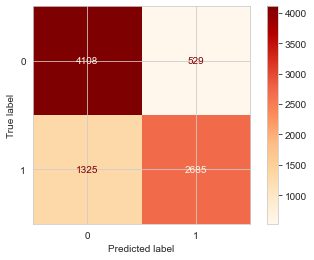

In [595]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')




We care more about recall than precision for two reasons:

 - conversion apps/messages is less important than apps/placements
 - reaching relevant carers could increase apps/placements and carer 'engagement'

On a balanced sample (around 50% each applied/not applied), the model
['predicted_value','days_worked_past_90','apps_past_7_days','carer_gender_FEMALE'] does a fair job at classifying positive examples
correctly, showing an accuracy of 77.7% together with i) a recall score of 62.7%
and ii) a precision of 81% on the evaluation set (not used for FS)



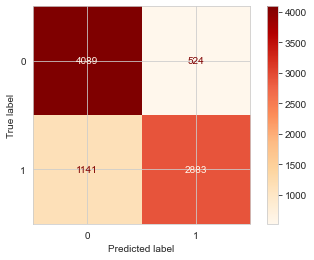

In [509]:
plot_confusion_matrix(model,X_eval[f_predictors],y_eval, cmap = 'OrRd')


  0%|          | 0/1000 [00:00<?, ?it/s]

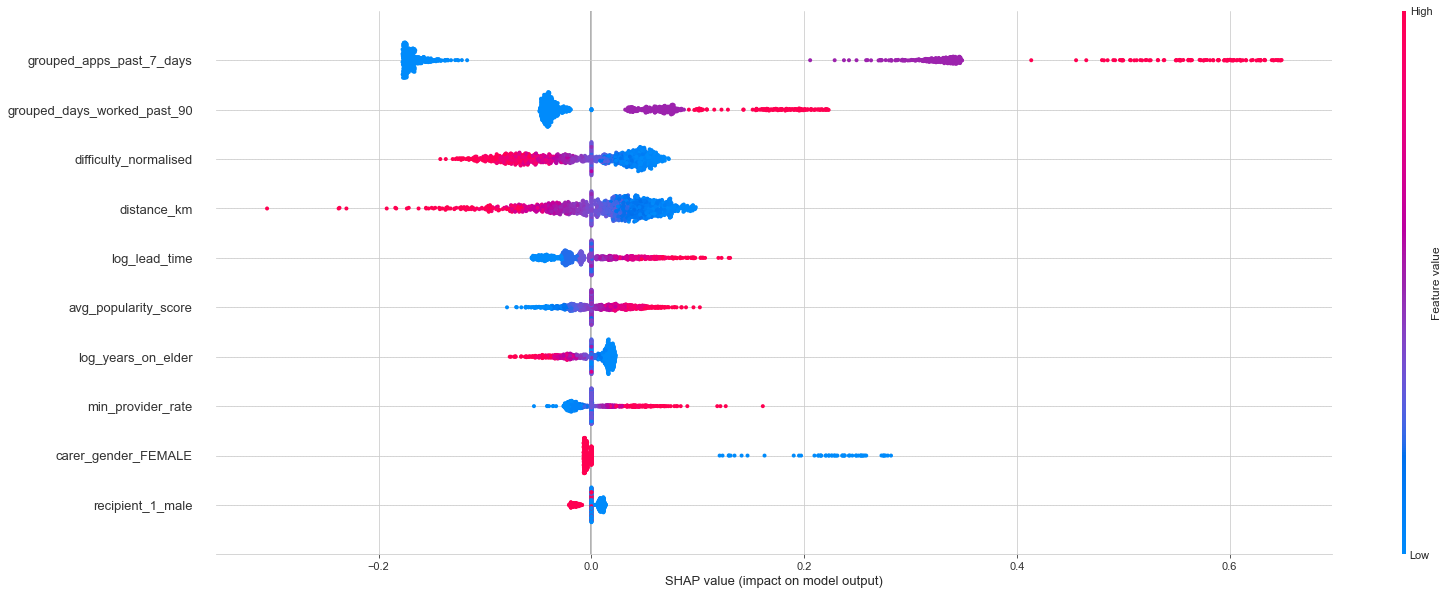

In [221]:
import warnings
warnings.filterwarnings('ignore')


scaler = StandardScaler()
scaler.fit(X_train[f_predictors])

masker = shap.maskers.Impute(data=scaler.transform(X_train[f_predictors]), )

model = LogisticRegression()
model.fit(X_eval[f_predictors],np.ravel(y_eval))

def model_predict_proba(x):
    return model.predict_proba(x)[:,1] #only returning probability of class 1

explainer = shap.KernelExplainer(model_predict_proba, X_train[f_predictors][:50], masker=masker)
shap_values = explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=10, show=False, plot_size=None )


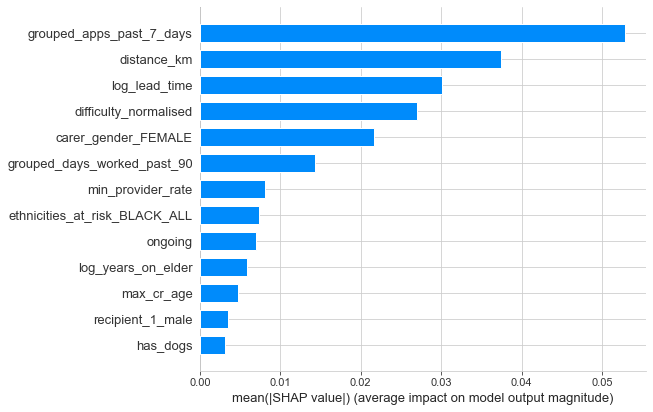

In [27]:
shap.summary_plot(shap_values, features=X_eval[f_predictors][:1000], feature_names=X_eval[f_predictors].columns, plot_type='bar')

## Testing tree-based models

#### Random forest

In [168]:

rf = RandomForestClassifier()
rf.fit(X_train[f_predictors], np.ravel(y_train))


preds = rf.predict(X_eval[f_predictors])

print(f'Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')


Recall is 0.80682, accuracy is 0.82862, precision is 0.82277


In [ ]:
importances = rf.feature_importances_
# importances[::-1].sort()
forest_importances = pd.DataFrame(importances, index=X_train[f_predictors].columns)
forest_importances['std'] = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.sort_values(by=0,ascending = False, inplace = True)
forest_importances[0].iloc[:10].plot.bar(yerr=forest_importances['std'].values[:10], ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Catboost

In [ ]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=3,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=False)
catboost.fit(X_train[f_predictors], np.ravel(y_train))

preds = catboost.predict(X_eval[f_predictors])
print(f'TRAIN Recall is {round(recall_score(y_train,catboost.predict(X_train[f_predictors])),5)}, accuracy is {round(accuracy_score(y_train,catboost.predict(X_train[f_predictors])),5)}, precision is {round(precision_score(y_train,catboost.predict(X_train[f_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

log_loss(y_eval,pred_probs)


#### XGB



In [380]:
ratio = float(np.sum(y_train.values == 0)) / np.sum(y_train.values == 1) #or sqrt to smooth it out a bit
ratio

1.117494376189652

In [492]:
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]
xgb = XGBClassifier()

xgb.fit(X_train[f_predictors], np.ravel(y_train),
        eval_metric = 'logloss',
        eval_set=[(X_eval[f_predictors],y_eval)],
        verbose = False,
        early_stopping_rounds=20)

preds = xgb.predict(X_eval[f_predictors])
print(f'TRAIN Recall is {round(recall_score(y_train,xgb.predict(X_train[f_predictors])),5)}, accuracy is {round(accuracy_score(y_train,xgb.predict(X_train[f_predictors])),5)}, precision is {round(precision_score(y_train,xgb.predict(X_train[f_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

min(xgb.evals_result()['validation_0']['logloss'])



TRAIN Recall is 0.8297, accuracy is 0.84539, precision is 0.84054
EVAL Recall is 0.82339, accuracy is 0.83266, precision is 0.82017


0.397358

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

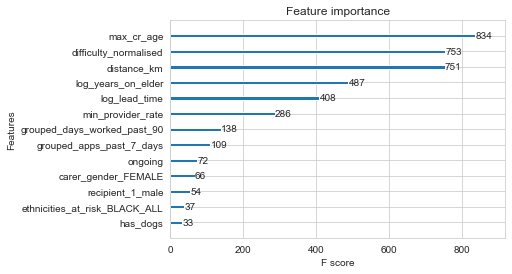

In [319]:
plot_importance(xgb, max_num_features=15)

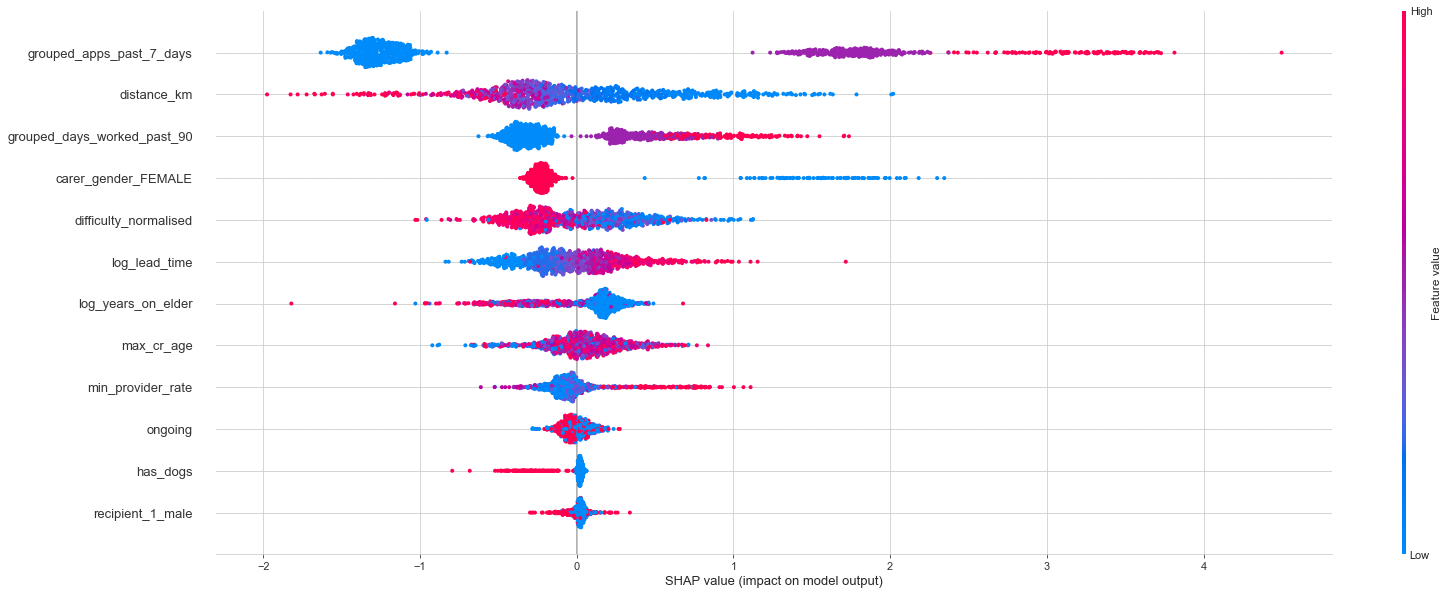

In [320]:
# scaler = StandardScaler()
# scaler.fit(X_train[f_predictors])
# masker = shap.maskers.Impute(data=scaler.transform(X_train[f_predictors]), )

masker = shap.maskers.Impute(data=X_train[f_predictors])

tree_explainer = shap.TreeExplainer(xgb,X_train[f_predictors][:100], masker=masker)
shap_values = tree_explainer.shap_values(X_eval[f_predictors][:1000])
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(1, 1, 1)
shap.summary_plot(shap_values, X_eval[f_predictors][:1000], max_display=12, show=False, plot_size=None )

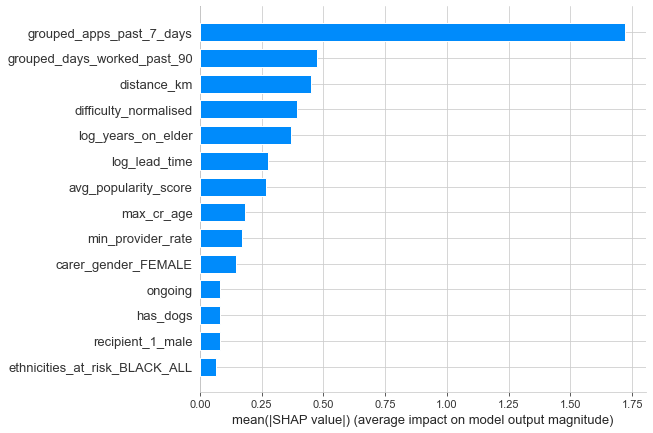

In [225]:
shap.summary_plot(shap_values, features=X_eval[f_predictors][:1000], feature_names=X_eval[f_predictors].columns, plot_type='bar')

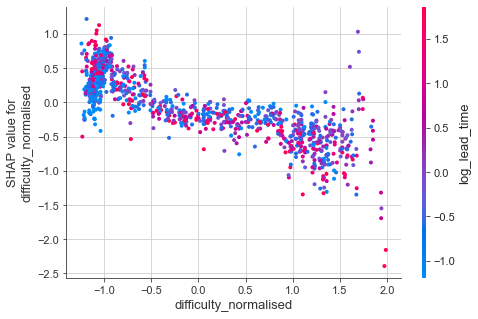

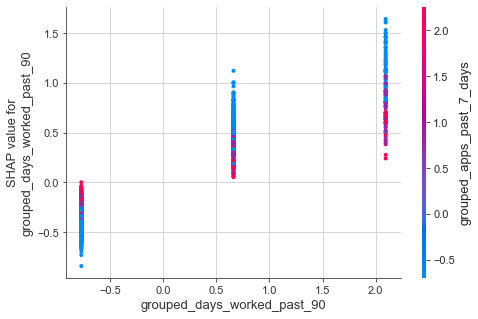

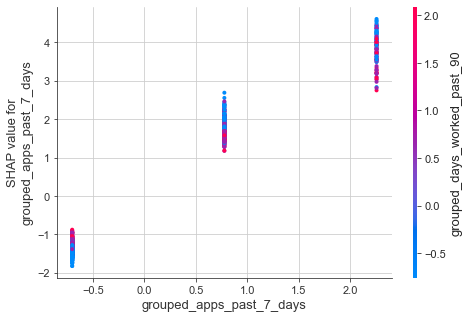

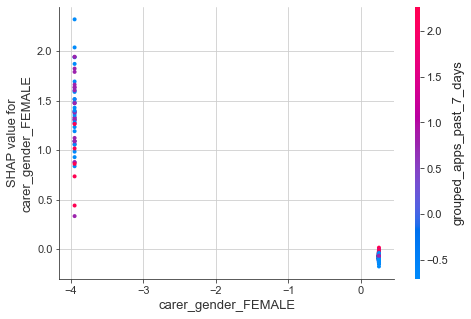

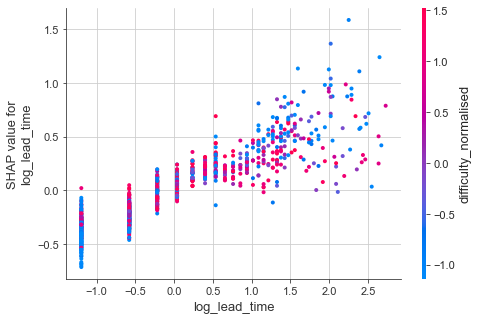

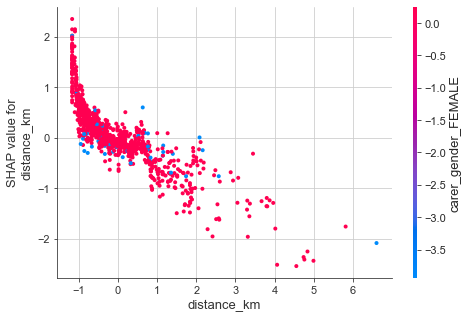

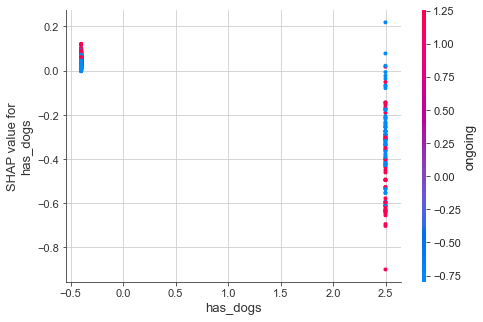

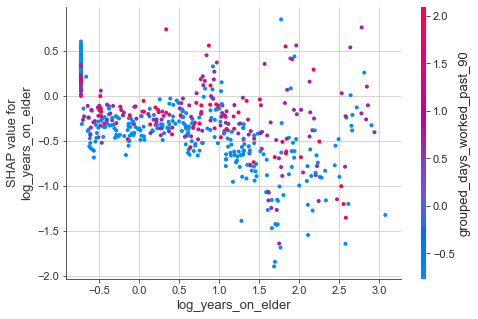

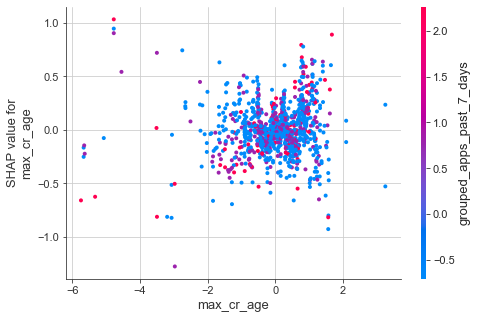

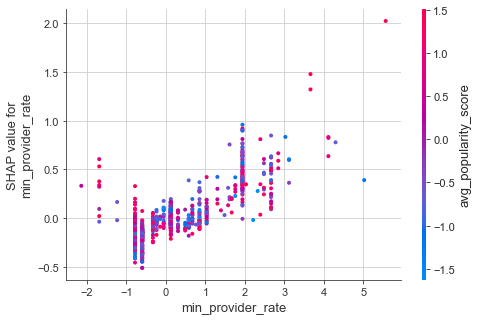

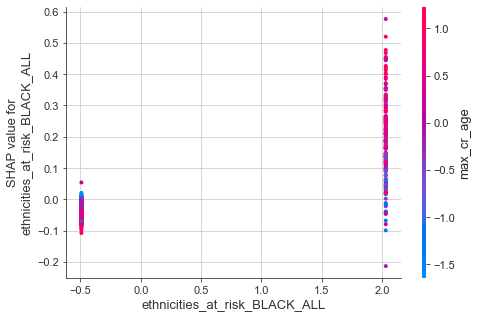

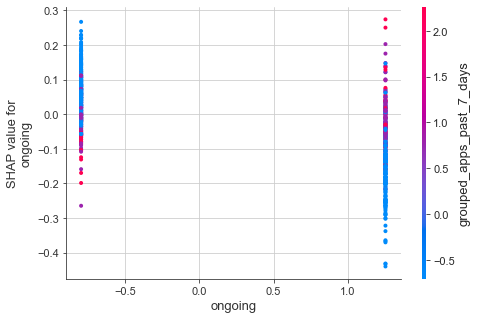

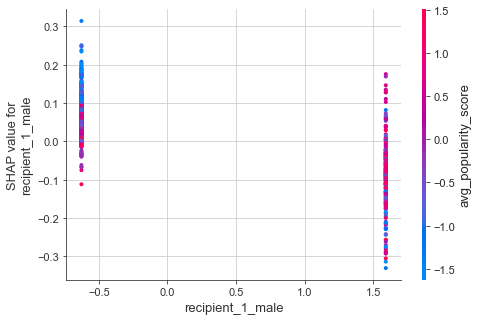

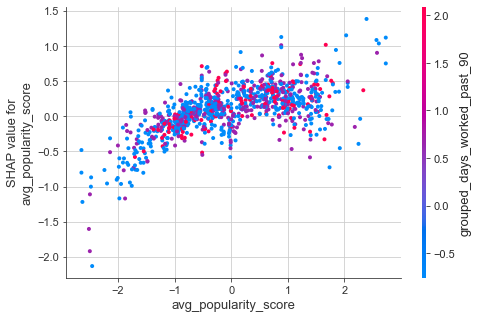

In [226]:
for f in f_predictors:
    shap.dependence_plot(f, shap_values, X_eval[f_predictors][:1000])

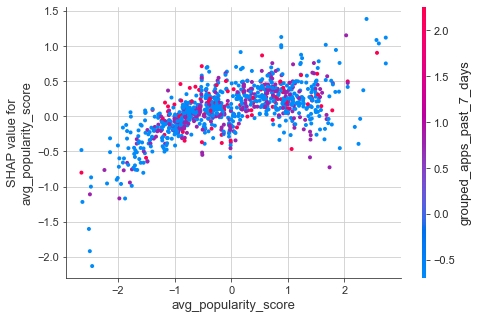

In [229]:
shap.dependence_plot("avg_popularity_score", shap_values, X_eval[f_predictors][:1000], interaction_index="grouped_apps_past_7_days")

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_eval[:1000])
shap.summary_plot(shap_interaction_values, X_eval[:1000], max_display=20)

## Testing matching vs model predictions


### On train/test split for all texts

In [455]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]

m_predictors = [
'distance_to_id','login_past_7_days'
]
model  = LogisticRegression()
model.fit(X_train[m_predictors], np.ravel(y_train))

preds = model.predict(X_eval[m_predictors])
pred_probs = model.predict_proba(X_eval[m_predictors])

print(f'TRAIN Recall is {round(recall_score(y_train,model.predict(X_train[m_predictors])),5)}, accuracy is {round(accuracy_score(y_train,model.predict(X_train[m_predictors])),5)}, precision is {round(precision_score(y_train,model.predict(X_train[m_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

log_loss(y_eval,pred_probs)
# balanced data
# TRAIN Recall is 0.50956, accuracy is 0.7488, precision is 0.77492
# EVAL Recall is 0.49821, accuracy is 0.74471, precision is 0.77315
#
# 0.5273478168298349

TRAIN Recall is 0.00432, accuracy is 0.99091, precision is 0.12346
EVAL Recall is 0.00289, accuracy is 0.99102, precision is 0.08462


0.047016478564891696

In [456]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]

m_predictors = [
'distance_to_id','login_past_7_days'
]
model  = LogisticRegression()
model.fit(X_train[f_predictors], np.ravel(y_train))

preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')

log_loss(y_eval,pred_probs)
# balanced data
# EVAL Recall is 0.72613, accuracy is 0.82887, precision is 0.81898
# 0.4199326855934228
# TRAIN Recall is 0.8297, accuracy is 0.84539, precision is 0.84054
# EVAL Recall is 0.82339, accuracy is 0.83266, precision is 0.82017
# 0.397358

EVAL Recall is 0.01105, accuracy is 0.9912, precision is 0.375


0.03788387019292983

### On train/test split for matching texts only

In [457]:
target = 'carer_applied_in_8hrs'

# X1 = all_data.loc[(all_data['carer_applied_in_8hrs']==1)&(all_data['sms_type']=='customListSent')]
# X0 = all_data.loc[(all_data['carer_applied_in_8hrs']==0)&(all_data['sms_type']=='customListSent')].sample(frac=0.01, random_state=1992)
# #&(all_data.avg_popularity_score.notnull())
# test_df = pd.concat([X1,X0], axis = 0)
test_df = all_data

test_df = test_df.loc[test_df.lead_time>0]
test_df['texts_past_30_days'].replace(np.nan,0,inplace = True)
test_df['login_past_7_days'].replace(np.nan,0,inplace = True)
test_df['apps_past_7_days'].replace(np.nan,0,inplace = True)
test_df['days_worked_past_90'].replace(np.nan,0,inplace = True)
test_df['carer_worked_in_7_days'].replace(np.nan,0,inplace = True)
test_df['carer_worked_in_30_days'].replace(np.nan,0,inplace = True)
test_df['carer_logged_in_7_days'].replace(np.nan,0,inplace = True)
test_df['viewed_placements_past_7_days'].replace(np.nan,0,inplace = True)

test_df['carer_logged_in_30_days'] = np.where(test_df['login_past_30_days']>0,1,0)

test_df['grouped_days_worked_past_90'] = np.where(test_df['days_worked_past_90'] == 0,0,np.nan)
test_df.loc[(test_df['days_worked_past_90']>0) & (test_df['days_worked_past_90']<=45) ,'grouped_days_worked_past_90'] = 1
test_df.loc[(test_df['days_worked_past_90']>45),'grouped_days_worked_past_90'] = 2

test_df['grouped_apps_past_7_days'] = np.where(test_df['apps_past_7_days'] == 0,0,np.nan)
test_df.loc[(test_df['apps_past_7_days']>0) & (test_df['apps_past_7_days']<8) ,'grouped_apps_past_7_days'] = 1
test_df.loc[(test_df['apps_past_7_days']>7),'grouped_apps_past_7_days'] = 2

test_df = test_df.loc[test_df.lead_time>0]
test_df['log_lead_time'] = np.log(np.where(test_df['lead_time']>0,test_df['lead_time'],0.01))
test_df['log_lead_time'] = test_df.log_lead_time.clip(0)

test_df['apps_past_7_days'].replace(np.nan,0,inplace = True)
test_df['days_worked_past_90'].replace(np.nan,0,inplace = True)

In [458]:
predictors = test_df.columns.tolist()

[predictors.remove(x) for x in [target,
'match_request_id',
'carer_id',
'customer_id',
'sent_at',
'updated_at',
'set_at',
'latitude',
'longitude',
'start_date_time',
'date',
'date_x',
'date_y',
'date_sent_at',
'carer_logged_in_7_days',
'texts_past_30_days',
'carer_worked_in_30_days',
  'viewed_placements_past_7_days',
'ratio_apps_views',
'predicted_value',
'popularity_score',
'sms_type'] if x in predictors]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [459]:
for p in predictors:
    if test_df[p].isna().sum()>0:
        print(p,test_df[p].isna().sum())

print(test_df.shape)
test_df = test_df.loc[test_df[predictors].notnull().all(axis=1)]
print(test_df.shape)

max_cr_age 19020
ethnicityExclusion_ARAB_ALL 11110
ethnicityExclusion_ASIAN_ALL 11110
ethnicityExclusion_BLACK_ALL 11110
ethnicityExclusion_MIXED_ALL 11110
ethnicityExclusion_WHITE_ALL 11110
genderExclusion_MALE 11110
maxDistance_50 11110
maxDistance_100 11110
maxDistance_400 11110
petsExclusion_CATS 11110
petsExclusion_DOGS 11110
recipientNumberExclusion_2CRs 11110
smokingClientsExclusion 11110
has_licence 11110
has_car 11110
carer_moving_handling 11110
carer_dementia 11110
carer_mental_health_issues 11110
carer_hoist 11110
carer_parkinsons 11110
carer_stroke 11110
carer_alzheimers 11110
carer_stoma 11110
carer_diabetes 11110
carer_peg 11110
carer_age 13502
log_career_years_of_experience 54028
log_years_on_elder 15761
carer_gender_FEMALE 11110
distance_km 8514
distance_to_id 3971
difficulty_normalised 4766
login_past_30_days 387217
(1832994, 89)
(1376162, 89)


In [460]:
X_train, X_eval, y_train, y_eval = split_train_test(test_df,predictors,target,test_size=0.25)

print(f'There are {X_train.placement_ad_id.nunique()} placements in the training set with {y_train.sum().values[0]} applications')
print(f'There are {X_eval.placement_ad_id.nunique()} placements in the eval set with {y_eval.sum().values[0]} applications')

X_train.drop('placement_ad_id', axis = 1, inplace= True)
X_eval.drop('placement_ad_id', axis = 1, inplace= True)

There are 13642 placements in the training set with 11378 applications
There are 12675 placements in the eval set with 3793 applications


In [461]:
scaler = StandardScaler()
model = LogisticRegression(max_iter=10000)

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_eval = pd.DataFrame(scaler.transform(X_eval), index=X_eval.index, columns=X_eval.columns)


In [464]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]

m_predictors = [
'distance_to_id'
]
model  = LogisticRegression()
model.fit(X_train[m_predictors], np.ravel(y_train))

preds = model.predict(X_eval[m_predictors])
pred_probs = model.predict_proba(X_eval[m_predictors])

print(f'TRAIN Recall is {round(recall_score(y_train,model.predict(X_train[m_predictors])),5)}, accuracy is {round(accuracy_score(y_train,model.predict(X_train[m_predictors])),5)}, precision is {round(precision_score(y_train,model.predict(X_train[m_predictors])),5)}')
print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')


log_loss(y_eval,pred_probs)
#balanced
# TRAIN Recall is 0.14223, accuracy is 0.62622, precision is 0.60663
# EVAL Recall is 0.13783, accuracy is 0.62365, precision is 0.5969
# 0.6506254900109963



TRAIN Recall is 0.0, accuracy is 0.98898, precision is 0.0
EVAL Recall is 0.0, accuracy is 0.98898, precision is 0.0


0.059972223927246104

In [463]:
 # 'days_worked_past_90',
f_predictors = [
'difficulty_normalised','grouped_days_worked_past_90','grouped_apps_past_7_days',
'carer_gender_FEMALE','log_lead_time','distance_km',
'has_dogs','log_years_on_elder', 'max_cr_age',
 'min_provider_rate','ethnicities_at_risk_BLACK_ALL', 'ongoing', 'recipient_1_male'
]

m_predictors = [
'distance_to_id'
]
model  = LogisticRegression()
model.fit(X_train[f_predictors], np.ravel(y_train))

preds = model.predict(X_eval[f_predictors])
pred_probs = model.predict_proba(X_eval[f_predictors])

print(f'EVAL Recall is {round(recall_score(y_eval,preds),5)}, accuracy is {round(accuracy_score(y_eval,preds),5)}, precision is {round(precision_score(y_eval,preds),5)}')


log_loss(y_eval,pred_probs)
# balanced
# EVAL Recall is 0.72613, accuracy is 0.82887, precision is 0.81898
# 0.4199326855934228


EVAL Recall is 0.01186, accuracy is 0.98891, precision is 0.39474


0.04638267567560237

## Evaluating the model on email data

In [476]:
email_data = pd.read_csv('../data/email_data.csv')
email_data

,carer_id,communication_at,carer_applied_in_8hrs
0,p100159862,2021-09-17 09:00:01,0
1,p100159862,2021-09-24 09:00:31,0
2,p100481747,2021-09-02 09:00:19,0
3,p100481747,2021-09-09 09:00:01,0
4,p100481747,2021-09-16 09:00:45,0
...,...,...,...
3513,p99123463,2021-09-03 09:05:02,0
3514,p99816556,2021-09-02 09:01:31,0
3515,p99816556,2021-09-09 09:03:50,0
3516,p99816556,2021-09-16 09:02:24,0


In [479]:
#store weights
import pickle
fn = f'../weights/fitted_xgb_2021-09-21.sav'

#loading weights
weights = pickle.load(open(fn, 'rb'))